<a href="https://colab.research.google.com/github/imaasthag/imaasthag.github.io/blob/master/Prediction_of_Drug_Permeability_of_Blood_Brain_Barrier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Dataset

In [ ]:
!pip install -q datasets rdkit scikit-learn matplotlib pandas numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split

dataset = load_dataset("maomlab/B3DB", name="B3DB_classification")
combined_df = pd.concat(
    [pd.DataFrame(dataset['train']), pd.DataFrame(dataset['test'])],
    ignore_index=True
)

train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['Y'],
    random_state=42
)

print("Train data")
print(train_df.head())

print("\nTest data")
print(test_df.head())


Train data
     B3DB_classification_index       compound_name  \
3542  B3DB_classification_4633           bupropion   
4237   B3DB_classification_147  takle-2; l-779,450   
7051  B3DB_classification_2489     phenolphthalein   
6421  B3DB_classification_4803        mirincamycin   
7493  B3DB_classification_5389          rebamipide   

                                             IUPAC_name  \
3542  2-(3,4-dichlorophenyl)-1-[2-(pyrrolidin-1-ylme...   
4237  2-chloro-5-(2-phenyl-5-pyridin-4-yl-1h-imidazo...   
7051        3,3-bis(4-hydroxyphenyl)-2-benzofuran-1-one   
6421  (2s)-n-[2-chloro-1-[(2r,3r,4s,5r,6r)-3,4,5-tri...   
7493  2-[(4-chlorobenzoyl)amino]-3-(2-oxo-1h-quinoli...   

                                                 SMILES        CID  logBB  Y  \
3542             O=C(Cc1ccc(Cl)c(Cl)c1)N1CCCCC1CN1CCCC1  5244802.0    NaN  1   
4237       Oc1cc(-c2nc(-c3ccccc3)[nH]c2-c2ccncc2)ccc1Cl  9950176.0   -1.0  1   
7051          O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21     4764.0   

Convert strings (SMILES) to numerical features (Morgan fingerprints)

In [ ]:
train_smiles, train_labels = train_df['SMILES'], train_df['Y']
test_smiles, test_labels = test_df['SMILES'], test_df['Y']

def smiles_to_fingerprints(smiles_list, radius=2, nBits=2048):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        arr = np.zeros((nBits,), dtype=int)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
            DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    return np.array(fps)

X_train = smiles_to_fingerprints(train_smiles)
X_test = smiles_to_fingerprints(test_smiles)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

Streaming output truncated to the last 5000 lines.
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:45:30] DEPRECATION WARNING: please use MorganGenerator
[19:4

Class Distribution

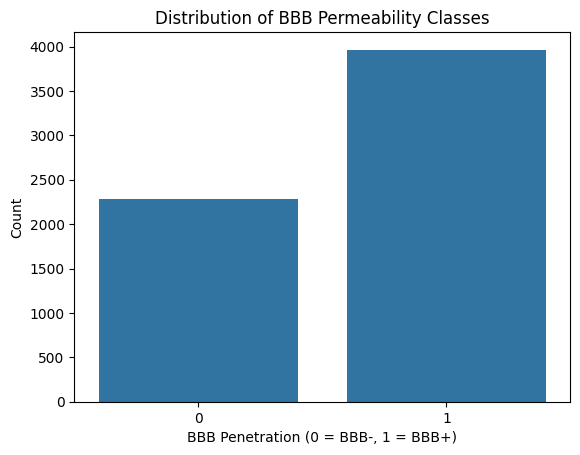

In [ ]:
import seaborn as sns
sns.countplot(x='Y', data=train_df)
plt.title("Distribution of BBB Permeability Classes")
plt.xlabel("BBB Penetration (0 = BBB-, 1 = BBB+)")
plt.ylabel("Count")
plt.show()

Algorithm 1: Random Forest Classifier

Evaluate:
AUC score: 0.7986


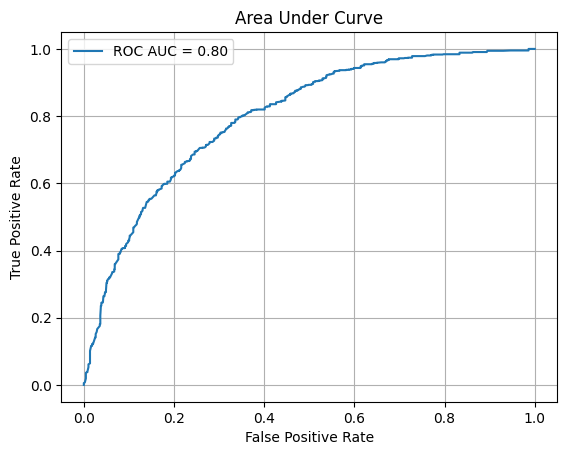

Precision Recall AUC Score: 0.8048


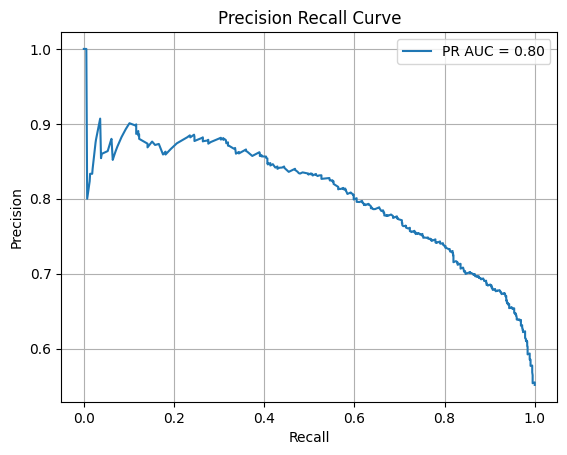

F1 score: 0.7692


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_probs = classifier.predict_proba(X_test)[:, 1]
y_preds = classifier.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)

print ("Evaluate:")

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 2: Logistic Regression

Evaluate:
AUC score: 0.7165


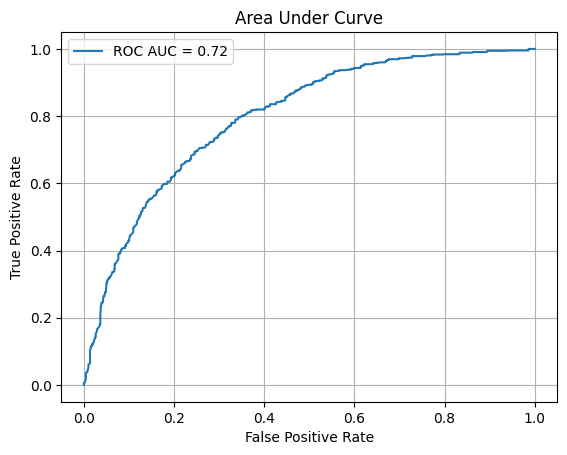

Precision Recall AUC Score: 0.7428


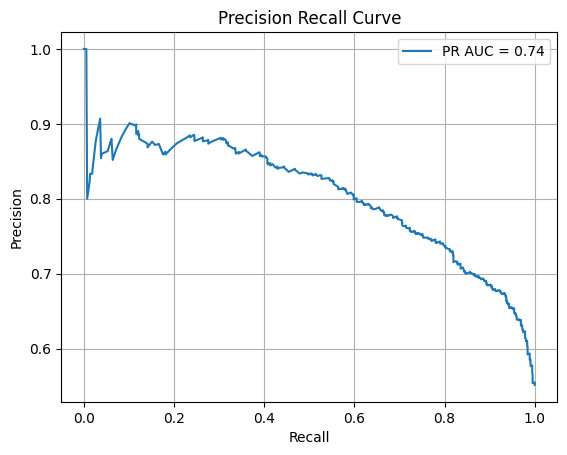

F1 score: 0.7312


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_probs = logreg.predict_proba(X_test)[:, 1]
y_preds = logreg.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print ("Evaluate:")

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 3: Gradient Boosting Machine

Evaluate:
AUC score: 0.7519


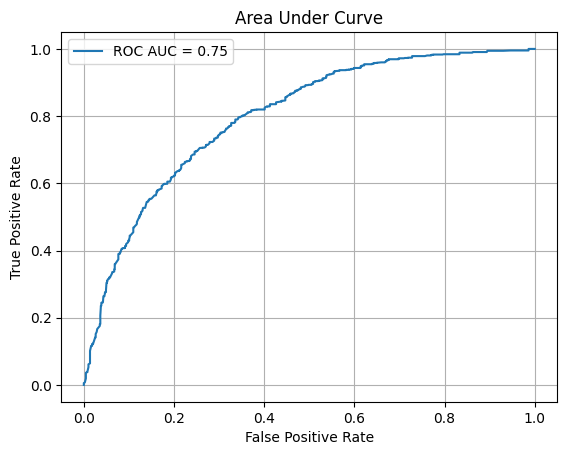

Precision Recall AUC Score: 0.7658


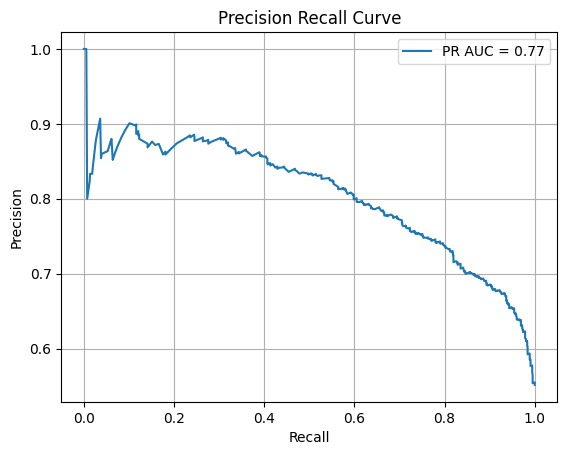

F1 score: 0.7545


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gradient = GradientBoostingClassifier(random_state=42)
gradient.fit(X_train, y_train)

y_probs = gradient.predict_proba(X_test)[:, 1]
y_preds = gradient.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print ("Evaluate:")

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 4: k-Nearest Neighbors

AUC score: 0.5291


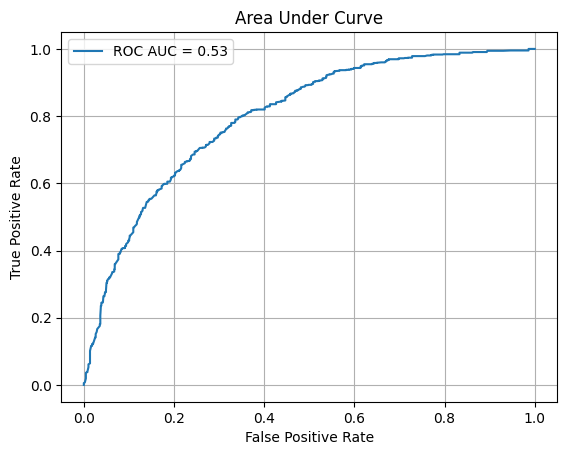

Precision Recall AUC Score: 0.5660


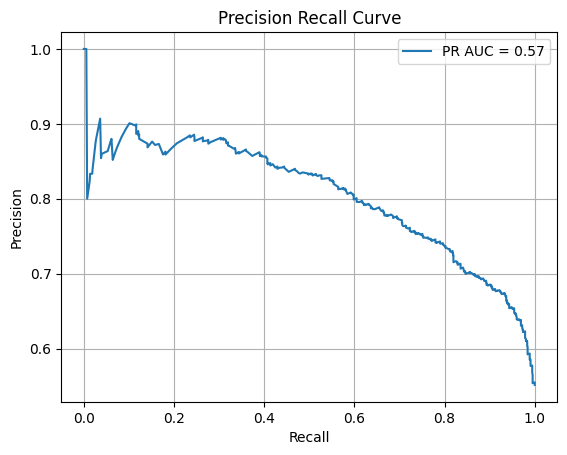

F1 score: 0.7137


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_probs = knn.predict_proba(X_test)[:, 1]
y_preds = knn.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 5: Neural Network

AUC score: 0.6834


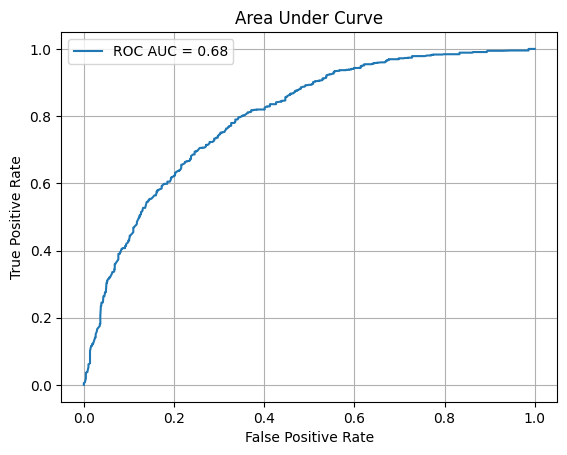

Precision Recall AUC Score: 0.6993


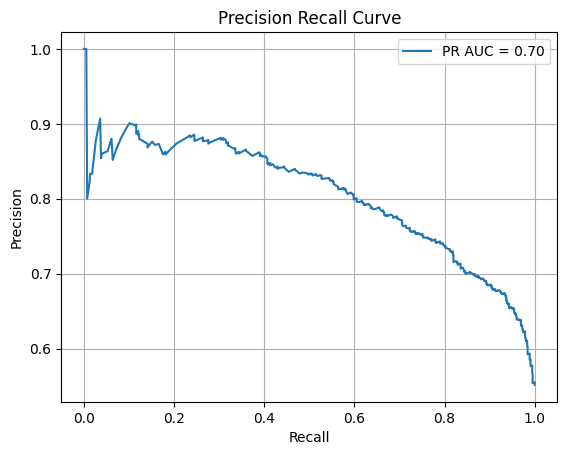

F1 score: 0.7221


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

y_probs = mlp.predict_proba(X_test)[:, 1]
y_preds = mlp.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 6: Naive Bayes

AUC score: 0.5231


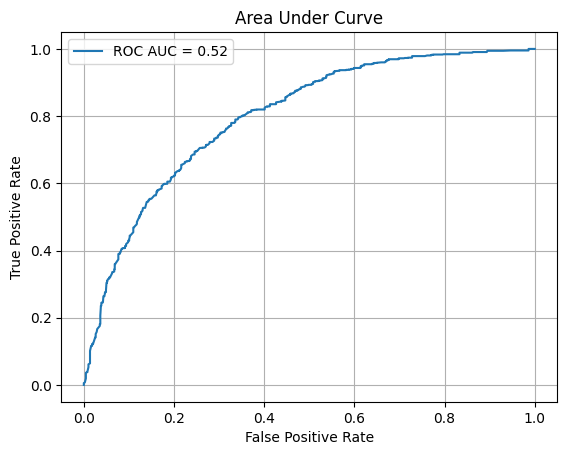

Precision Recall AUC Score: 0.5561


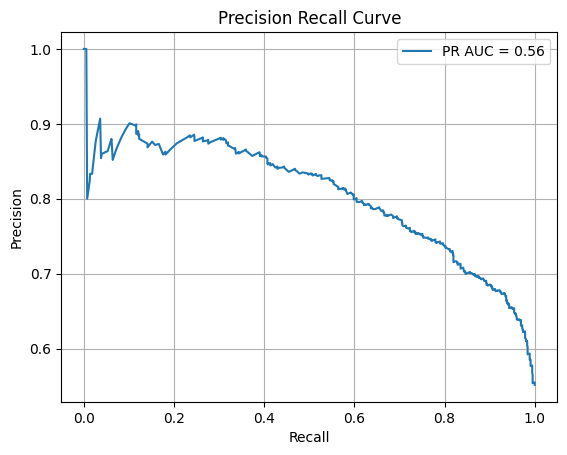

F1 score: 0.5070


In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_probs = nb.predict_proba(X_test)[:, 1]
y_preds = nb.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 7: Support Vector Machine

AUC score: 0.8047


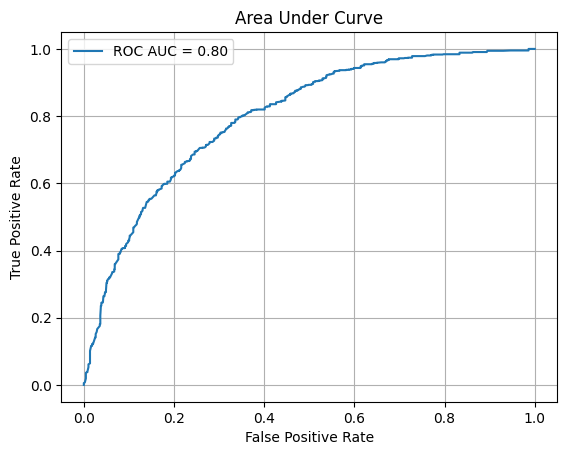

Precision Recall AUC Score: 0.8082


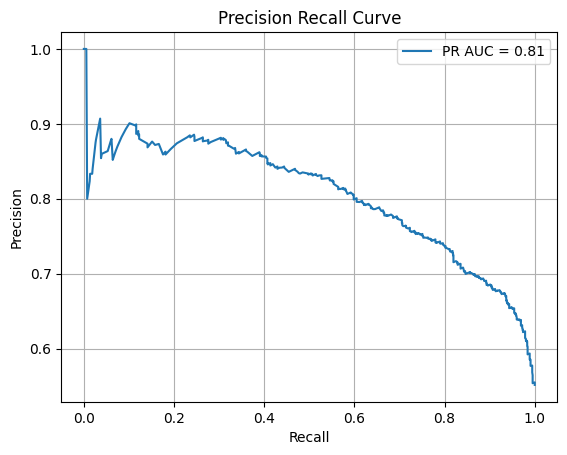

F1 score: 0.7811


In [ ]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

y_probs = svm.predict_proba(X_test)[:, 1]
y_preds = svm.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Algorithm 8: Decision Trees

AUC score: 0.5952


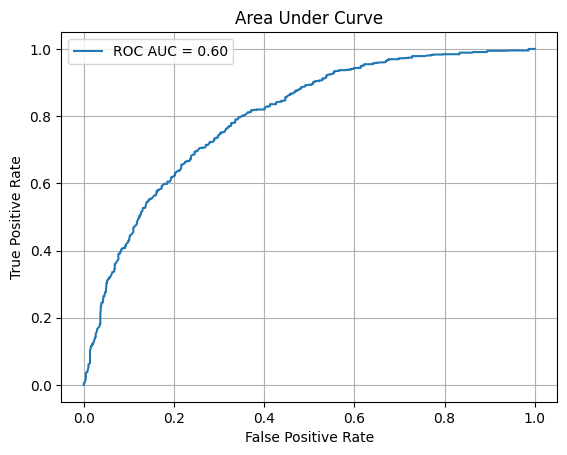

Precision Recall AUC Score: 0.6056


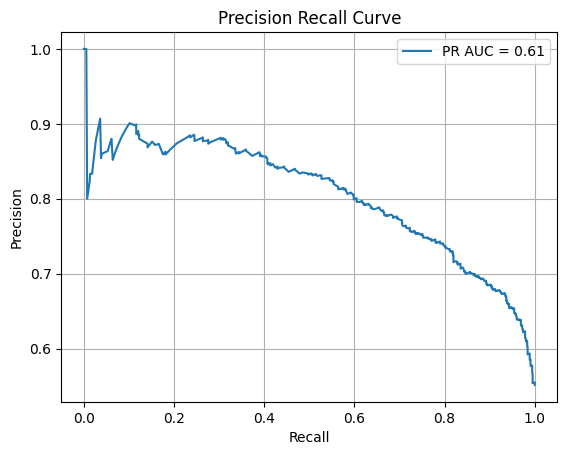

F1 score: 0.6928


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_probs = dt.predict_proba(X_test)[:, 1]
y_preds = dt.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

Compare Evaluation Metrics across 8 algorithms

Training and evaluating: Random Forest
Training and evaluating: Logistic regression
Training and evaluating: Gradient Boosting Machine
Training and evaluating: k-Nearest Neighbors
Training and evaluating: Neural Network
Training and evaluating: Naive Bayes
Training and evaluating: Support Vector Machine
Training and evaluating: Decision Trees
Evaluation Metrics Comparison:
                       Model  F1 Score   ROC AUC    PR AUC
0              Random Forest  0.769174  0.798614  0.804831
1        Logistic regression  0.731191  0.716533  0.742803
2  Gradient Boosting Machine  0.754532  0.751928  0.765764
3        k-Nearest Neighbors  0.713699  0.529129  0.565985
4             Neural Network  0.722135  0.683354  0.699335
5                Naive Bayes  0.507028  0.523056  0.556055
6     Support Vector Machine  0.781142  0.804729  0.808226
7             Decision Trees  0.692843  0.595159  0.605575


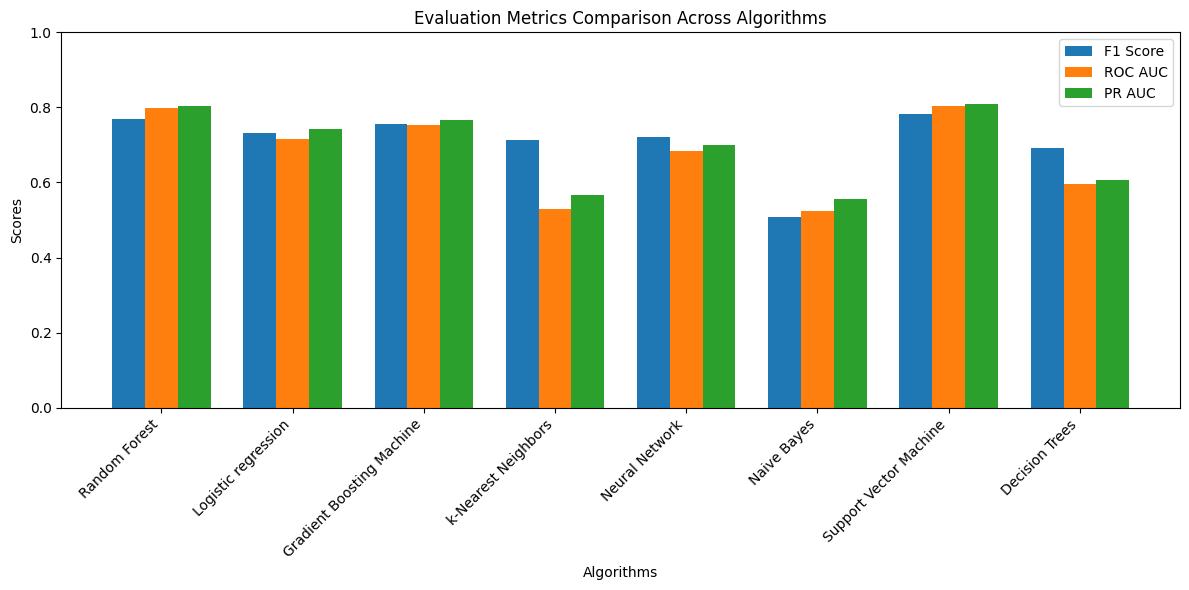

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting Machine": GradientBoostingClassifier(random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Decision Trees": DecisionTreeClassifier(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training and evaluating: {name}")
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
      y_probs = model.decision_function(X_test)

    y_preds = model.predict(X_test)

    f1 = f1_score(y_test, y_preds)
    roc_auc = roc_auc_score(y_test, y_probs)
    pr_auc = average_precision_score(y_test, y_probs)

    results.append({
        "Model": name,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    })

results_df = pd.DataFrame(results)

print("Evaluation Metrics Comparison:")
print (results_df)

index = np.arange(len(results_df))

index = np.arange(len(results_df))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(index - width, results_df["F1 Score"], width=width, label="F1 Score")
plt.bar(index, results_df["ROC AUC"], width=width, label="ROC AUC")
plt.bar(index + width, results_df["PR AUC"], width=width, label="PR AUC")

plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Evaluation Metrics Comparison Across Algorithms")
plt.xticks(index, results_df["Model"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


Optimization

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Support Vector Machine Optimization Results:
AUC score: 0.7750


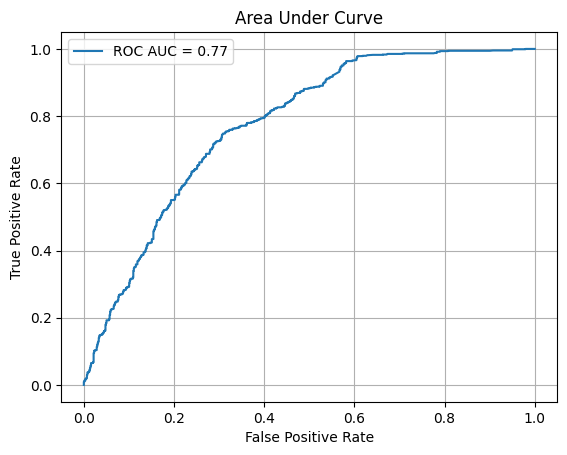

Precision Recall AUC Score: 0.7673


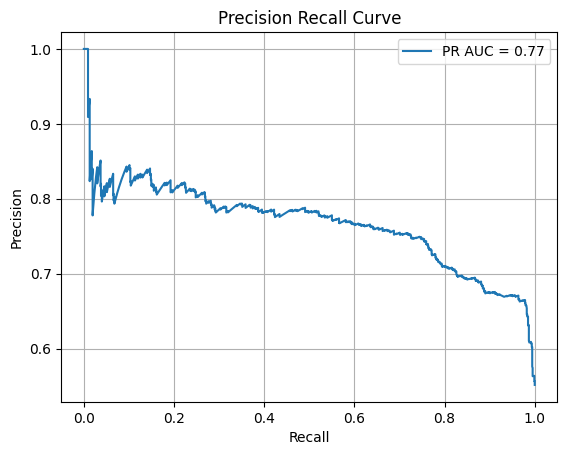

F1 score: 0.7567
Optimized parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Optimized F1 Score: 0.7567
Optimized ROC AUC: 0.7750
Optimized PR AUC: 0.7673


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

y_probs = best_svm.predict_proba(X_test)[:, 1]
y_preds = best_svm.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)

print("Support Vector Machine Optimization Results:")
print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

print("Optimized parameters:", grid_search.best_params_)
print(f"Optimized F1 Score: {f1:.4f}")
print(f"Optimized ROC AUC: {roc_auc:.4f}")
print(f"Optimized PR AUC: {pr_auc:.4f}")

Support Vector Machine Optimization Results:
AUC score: 0.7594


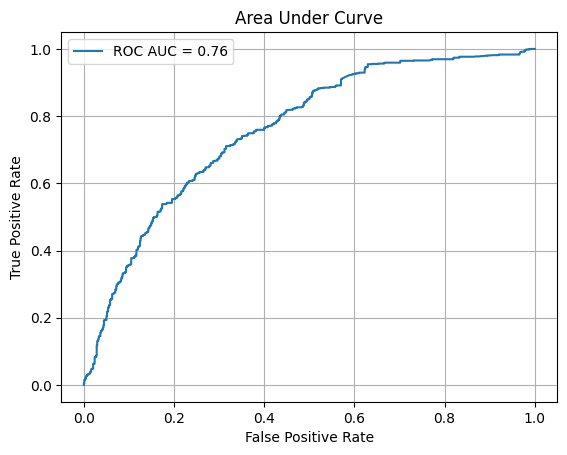

Precision Recall AUC Score: 0.7644


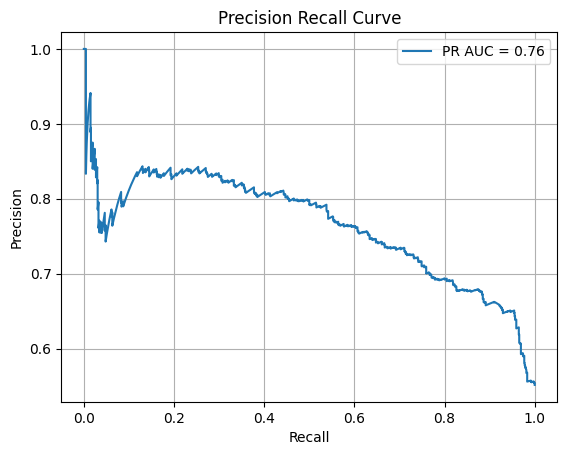

F1 score: 0.7608
Optimized parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Optimized F1 Score: 0.7608
Optimized ROC AUC: 0.7594
Optimized PR AUC: 0.7644


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
)

svm.fit(X_train, y_train)

y_probs = svm.predict_proba(X_test)[:, 1]
y_preds = svm.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)

print("Support Vector Machine Optimization Results:")
print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 score: {f1:.4f}")

print("Optimized parameters:", grid_search.best_params_)
print(f"Optimized F1 Score: {f1:.4f}")
print(f"Optimized ROC AUC: {roc_auc:.4f}")
print(f"Optimized PR AUC: {pr_auc:.4f}")

Final Graphs

Final Test Performance – Support Vector Machine
AUC score: 0.9153


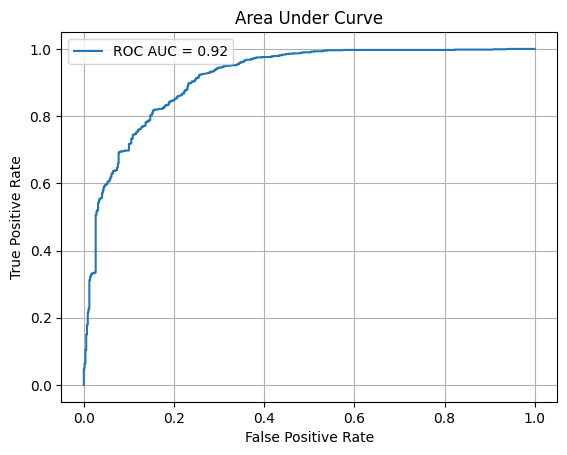

Precision Recall AUC Score: 0.9403


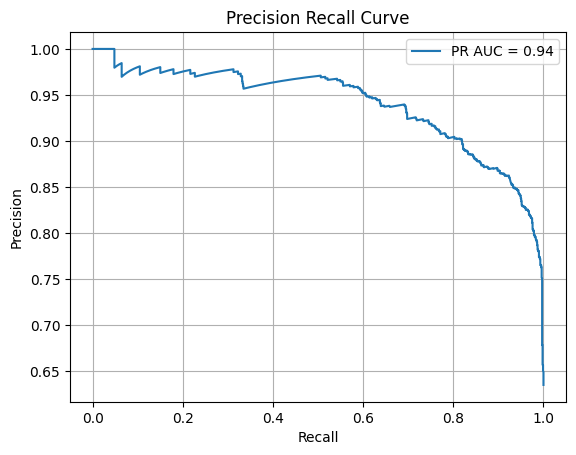

F1 Score: 0.8727
ROC AUC: 0.9153
PR AUC: 0.9403


In [ ]:
svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=0.1, gamma='scale', probability=True, random_state=42)
)

svm.fit(X_train, y_train)

y_probs = svm.predict_proba(X_test)[:, 1]
y_preds = svm.predict(X_test)

f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)

print("Final Test Performance – Support Vector Machine")

print(f"AUC score: {roc_auc:.4f}")
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision Recall AUC Score: {pr_auc:.4f}")
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

Reference:

@article

Meng_A_curated_diverse_2021,

author = {Meng, Fanwang and Xi, Yang and Huang, Jinfeng and Ayers, Paul W.},

doi = {10.1038/s41597-021-01069-5},

journal = {Scientific Data},

number = {289},

title = {A curated diverse molecular database of blood-brain barrier permeability with chemical descriptors},

volume = {8},

year = {2021},

url = {https://www.nature.com/articles/s41597-021-01069-5},

publisher = {Springer Nature}
